# **Black Jack  Reinforcement Learning and Monte Carlo Methods**

## BlackJack Environment 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/blackjack.gif" width="30%" alt="iris image"  />

**Blackjack** is a card game played against a dealer. At the start of a round, both player and dealer are dealt 2 cards. The player can only see one of the dealer’s cards. The goal of the game is to get the value of your cards as close to 21 as possible, without crossing 21. The value of each card is listed below.

* 10/Jack/Queen/King → 10
* 2 through 9 → Same value as card
* Ace → 1 or 11 (Player’s choice). Note that ace is called useful when It can be counted as 11 without going bust.

If the player has less than 21, they can choose to “hit” and receive a random card from the deck. They can also choose to “stand” and keep the cards they have. If the player exceeds 21, they go “bust” and automatically lose the round. If the player has exactly 21, they automatically win. Otherwise, the player wins if they are closer to 21 than the dealer.

The observation of is a 3-tuple of: the player's (you) current sum, the dealer's one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1) or (`True` or `False`).

    Tuple(the players current sum, dealer's one showing card player holds, usable ace (0 or 1) )
    
`Tuple(Discrete(32), Discrete(11), Discrete(2))` as
* The highest score you can achieve is (11,10,11), and the lowest is (1), so there are 32 states for the player's score.
* The dealer only shows one card, which can be anything from 1 to 11
* The 'usable ace' space is True/False, so the size of the space is 2.

So there are $32 \times 11 \times 2 = 704$ possible states. Note that we have to reset the environment to start working with it. This function resets the game environment to what it was when you started the game. It will return the initial state $S_0$:



### Importing Required Libraries

In [ ]:
import sys
sys.path.append('/Users/artem/opt/anaconda3/lib/python3.9/site-packages')

import gym
import matplotlib.pyplot as plt
import math 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import defaultdict


from blackjackutility import get_total, game_result

### Defining Helper Functions

In [8]:
def plot_value_function(V):
    """
    plot the estimated value function for blackjack 
    Returns:  void plots value function 
    Args:
    V: a dictionary of estimated values for blackjack 
    """
    #range of player score  
    player=[state[0]  for state in  V.keys()]
    max_player=max(player)
    min_player=min(player)
    player_range=np.arange(min_player, 22, 1)
    #range of dealer score      
    dealer=[state[1]  for state in  V.keys()]
    max_dealer=max(dealer)
    min_dealer=min(dealer)
    dealer_range=np.arange(min_dealer, 11, 1)
    #empty array for the value function, first access in the players score second  is the dealer, third is if  there  is an ace    
    V_plot=np.zeros((21-min_player+1,max_dealer-min_dealer+1,2))
    #create a mesh grid for plotting 
    X,Y = np.meshgrid(dealer_range,player_range)

    #populate an array  of values for different  scores not including losing scores 
    for (player,dealer,ace),v in V.items():
        if player<=21 and dealer<=21:
            V_plot[player-min_player,dealer-min_dealer,(1*ace)]=V[(player,dealer,ace)]

    #plot surface        
    fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': '3d'})
    ax[0].plot_wireframe(X,Y, V_plot[:,:,0])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ')
    ax[0].set_zlabel('value function')
    ax[1].plot_wireframe(X,Y, V_plot[:,:,1])
    ax[1].set_title('no ace')
    ax[1].set_xlabel('dealer')
    ax[1].set_ylabel('player ')
    ax[1].set_zlabel('value function')
    ax[1].set_title(' ace')
    fig.tight_layout()
    plt.show()

    #plot top view of the surface     
    fig, ax = plt.subplots(nrows=1, ncols=2)   
    ax[0].imshow((V_plot[:,:,0]),extent =[1,10,21,4])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ')   
    im=ax[1].imshow(V_plot[:,:,1],extent =[1,10,21,4])
    ax[1].set_title('ace')
    ax[1].set_xlabel('dealer')
    fig.colorbar(im, ax=ax[1])
    

In [30]:
def random_action(action,epsilon=0.1,n_actions=2):
    ''' 
    This function takes the best estimated action, eplsilon, and action space 
    and returns some action. 
    '''
    # generate a random number from 0 to 1.
    number = np.random.rand(1)
    
    # if number is smaller than 1-epsilon then return best estimated action
    if number<1-epsilon:
        return action
    # if number is bigger or equals to 1-epsilon then return some random action from the action space
    else:
        action=np.random.randint(n_actions)  
        return action 

In [ ]:
def plot_policy_blackjack(policy):
    """
    plot the policy for blackjack 
    Returns:  void plots policy function 
    Args:
    policy: a dictionary of estimated values for blackjack 
    """    
    #range of player score 
    player=[state[0]  for state in  policy.keys()]
    max_player=max(player)
    min_player=min(player)
    #this vale is use in RL book 
    #min_player=12
    player_range=np.arange(min_player, 22, 1)
    #range of dealer score      
    dealer=[state[1]  for state in policy.keys()]
    max_dealer=max(dealer)
    min_dealer=min(dealer)
    dealer_range=np.arange(min_dealer, 11, 1)
    #empty array for the value function, first access in the players score second  is the dealer, third is if  there  is an ace    
    policy_plot=np.zeros((21-min_player+1,max_dealer-min_dealer+1,2))
    #create a mesh grid for plotting 
    X,Y = np.meshgrid(dealer_range,player_range)
    
    
    #populate an array  of values for different  policy not including losing states above 21 
    for (player,dealer,ace),v in policy.items():
        if player<=21 and dealer<=10 and player>=min_player:
            policy_plot[player-min_player,dealer-min_dealer,(1*ace)]=policy[(player,dealer,ace)]

    
    fig, ax = plt.subplots(nrows=1, ncols=2)   
    ax[0].imshow((policy_plot[:,:,0]),cmap=plt.get_cmap('GnBu', 2),extent =[1,10,21,4])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ') 
    

    ax[1].set_title('ace')
    ax[1].set_xlabel('dealer')
    im=ax[1].imshow(policy_plot[:,:,1],extent =[1,10,21,4],cmap=plt.get_cmap('GnBu', 2))
    fig.colorbar(im, ax=ax[1],ticks=[0 , 1])

In [36]:
def average_wins(environment,policy=None,episodes=10):
    """
    This function calculates the average number of wins for a game of blackjack given a policy.
    If no policy is provided a random policy is selected.
    Returns: average_wins: the average number of wins 
    std_wins: the average number of wins 
    Args:
    environment:AI gym balckjack envorment object 
    policy:policy for blackjack if none a random  action will be selected 
    episodes: number of episodes 
    """

    win_loss=np.zeros(episodes)

    for episode in range(episodes):
        state=environment.reset()
        done=False

        while (not(done)):
            if policy and isinstance(policy[state],np.int64):
                 
                action=policy[state]
                
            else:
                action=environment.action_space.sample()

            state,reward,done,info=environment.step(action)
        result=game_result(environment,state,show=False)
        if reward==1:
            win_loss[episode]=1
        else:
            win_loss[episode]=0  

        
    average_wins=win_loss.mean()
    std_win=win_loss.std()/np.sqrt(episodes)

    return average_wins ,std_win

## Expreriment:

Initialize the environment and view the observation space:

In [20]:
environment= gym.make('Blackjack-v1')
environment.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

Check the player and dealers cards:

In [21]:
print(environment.observation_space.sample())
print(environment.player)
print(environment.dealer)

(12, 2, 1)
[2, 10]
[5, 8]


Random Episodes:

In [23]:
episodes=2
sum_=0
result=0
error=0

#setting the seed for reproduceability

for episode in range(episodes):
    state=environment.reset()
    done=False
    print("_________________________________________")
    print("episode {}".format(episode))
   

    print("state:",state)
    print("player has", environment.player)
    print("the players current sum: {},\n  dealer's one showing card: {}, usable ace: {}".format(state[0],state[1],state[2]))
    print('dealer', environment.dealer)
    while (not(done)):
    
        action = environment.action_space.sample()
       
        if action:
            print("hit")
        else:
            print("stay")
        
        print("action:",action)

        state,reward,done,info = environment.step(action)
    print("Done :", done)
    result=game_result(environment,state)
    sum_+=reward
sum_

_________________________________________
episode 0
state: (16, 7, False)
player has [9, 7]
the players current sum: 16,
  dealer's one showing card: 7, usable ace: False
dealer [7, 1]
hit
action: 1
hit
action: 1
Done : True
state: (27, 7, False)
player has [9, 7, 1, 10]
the players current sum:27,dealer's one showing card:7, usable ace:False
dealer cards: [7, 1] and score: 18 your score i: 27 
Bust
_________________________________________
episode 1
state: (6, 6, False)
player has [3, 3]
the players current sum: 6,
  dealer's one showing card: 6, usable ace: False
dealer [6, 6]
hit
action: 1
hit
action: 1
Done : True
state: (22, 6, False)
player has [3, 3, 10, 6]
the players current sum:22,dealer's one showing card:6, usable ace:False
dealer cards: [6, 6] and score: 12 your score i: 22 
Bust


-2.0

## Define Monte Carlo Method:

Using a value function $V(s)$ for some state $s$ as an indication of what our model thinks the expected return is  when following the best action given by the Q function. So $V(s) = max(Q(s,a))$ for all $a$ in the action space. Our implementation returns the value function $V$ as a dictionary. $DELTA$ indicates the value by which the $V$ function for each state was updated, for example if $V_0(s) = 0.7$ and after the next episode $V_1(s) = 0.9$ then $DELTA$ is $0.9 - 0.7 = 0.2$.  The last parameter is $theta$, that indicated a stoping threshold, so if delta is very small, there is no reason to continue training the algorithm, since updates to the values are minimal we will stop the training process. 

In [31]:
def monte_carlo( environment,N_episodes=100000, discount_factor=1,first_visit=True, epsilon =0.1, theta=0.0001):
    """
    plot the policy for blackjack 
    Returns:  
    policy: a dictionary of estimated policy for blackjack 
    V: a dictionary of estimated values for blackjack 
    Q: a dictionary of estimated action function
    DELTA: list of deltas for each episode 
    Args:
    environment:AI gym balckjack envorment object 
    N_episodes:number of episodes 
    discount_factor:discount factor
    first_visit: select first-visit MC (Ture) and every-visit MC (False)
    epsilon: epsilon value 
    theta:stoping threshold
    """  
    #a dictionary of estimated values for blackjack 
    V=defaultdict(float)
    #a dictionary of estimated action function for blackjack
    Q=defaultdict(float)
    # number of visits to the action function 
    NumberVisitsValue= defaultdict(float)
    # visits to action function
    NumberVisits= defaultdict(float)
    #dictionary  for policy 
    policy=defaultdict(float) 
    #number  of actions 
    number_actions=environment.action_space.n
    #list of max difference between  value functions per  iteration 
    DELTA=[]

    for i in range(N_episodes):
        #max difference between  value functions
        delta=0
        #list that stores each state and reward for each episode     
        episode=[]
        # reset the  environment for the next episode and find first state  
        state=environment.reset()   
        #reward for the first state
        reward=0.0
        #flag for end of episodes  
        done=False
        #action for the first state 
        action=np.random.randint(number_actions)
        #append firt state, reward and action
        episode.append({'state':state , 'reward':reward,'action':action})
        #Past states for signal visit  Monte Carlo 
        state_action=[(state,action)]
        #enumerate for each episode 
        while not(done):

                #take action and find next state, reward and check if the episode is  done (True)
                (state, reward, done, prob) = environment.step(action)

                #check if a policy for the state exists  
                if isinstance(policy[state],np.int64):
                    #obtain action from policy
                    action=int(policy[state])
                    random_action(action,epsilon,number_actions)
                else:
                     #if no policy for the state exists  select a random  action  
                    action=np.random.randint(number_actions)
                #add state reward and action to list 
                episode.append({'state':state , 'reward':reward,'action':action})
                #add  states action this is for fist visit only 
                state_action.append((state,action))
         #reverse list as the return is calculated from the last state
        episode.reverse()
        #append the state-action pairs to a list 
        state_action.reverse()


        #determine the return
        G=0

        for t,step in enumerate(episode):

                #check flag for first visit
                G=discount_factor*G+step['reward']
                #check flag for first visit
                if first_visit:
                    #check if the state has been visited before 
                    if (step['state'],step['action']) not in set(state_action[t+1:]): 

                        #increment counter for action 
                        NumberVisits[step['state'],step['action']]+=1
                        #increment counter for value function 
                        NumberVisitsValue[step['state']]+=1
                        #if the action function value  does not exist, create an array  to store them 
                        if not(isinstance(Q[step['state']],np.ndarray) ):
                            Q[step['state']]= np.zeros((number_actions))

                        #calculate mean of action function Q Value functions V using the  recursive definition of mean 
                        Q[step['state']][step['action']]=Q[step['state']][step['action']]+(NumberVisits[step['state'],step['action']]**-1)*(G-Q[step['state']][step['action']])
                        
                        # record the old value of the value function 

                        v=V[step['state']]
                        
                        V[step['state']]=V[step['state']]+(NumberVisitsValue[step['state']]**-1)*(G-V[step['state']])
                        #update the policy to select the action fuciton argment with the largest value 
                        policy[step['state']]=np.random.choice(np.where(Q[step['state']]==Q[step['state']].max())[0])
                        #find max difference between all value functions per  iteration 
                        delta=max(delta,abs(v-V[step['state']]))


                else:
                         #increment counter for action 
                        NumberVisits[step['state'],step['action']]+=1
                        #increment counter for value function 
                        NumberVisitsValue[step['state']]+=1
                        #if the action function value  does not exist, create an array  to store them 
                        if not(isinstance(Q[step['state']],np.ndarray) ):
                            Q[step['state']]= np.zeros((number_actions))

                        #calculate mean of action function Q Value functions V using the  recursive definition of mean 
                        Q[step['state']][step['action']]=Q[step['state']][step['action']]+(NumberVisits[step['state'],step['action']]**-1)*(G-Q[step['state']][step['action']])
                        v=V[step['state']]
                        V[step['state']]=V[step['state']]+(NumberVisitsValue[step['state']]**-1)*(G-V[step['state']])
                        ##update the policy to select the action functioon argument with the largest value 
                        policy[step['state']]=np.random.choice(np.where(Q[step['state']]==Q[step['state']].max())[0])
                        #find max difference between all value functions per  iteration 
                        delta=max(delta,abs(v-V[step['state']]))
            
        DELTA.append(delta)
        if delta<theta:
            break

    return policy, V, Q,DELTA

Perform Monte Carlo training with 20000 episodes to see the results of our training.  

In [32]:
 policy, V, Q,DELTA= monte_carlo(environment,N_episodes=20000, discount_factor=1,epsilon = 0.1,first_visit=True,theta=0)  

Plot the delta value for each episode to see how the update rates are changing:

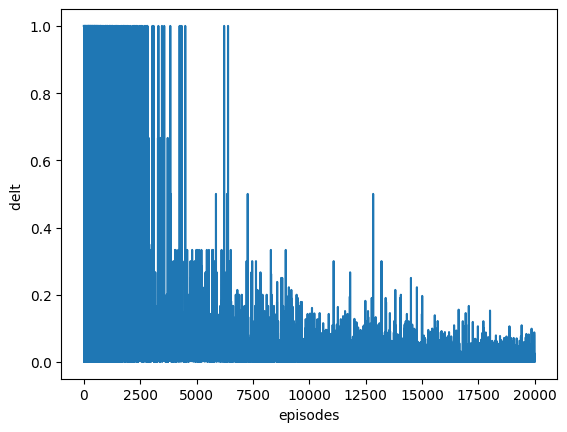

In [33]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt ")
plt.show()

The delta parameter is generally decreasing so our model comes closer and closer to the optimal values for the value function. Display the map of expected returns based on what player has and what the dealer has. 

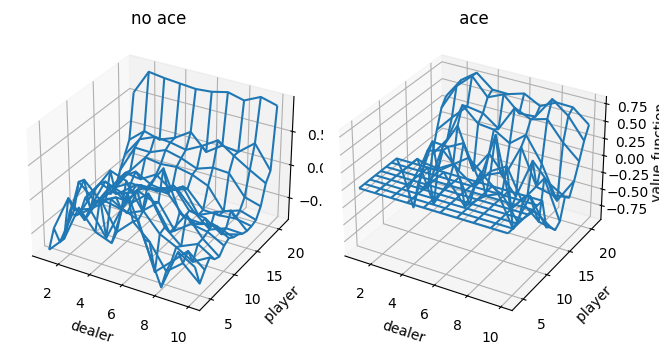

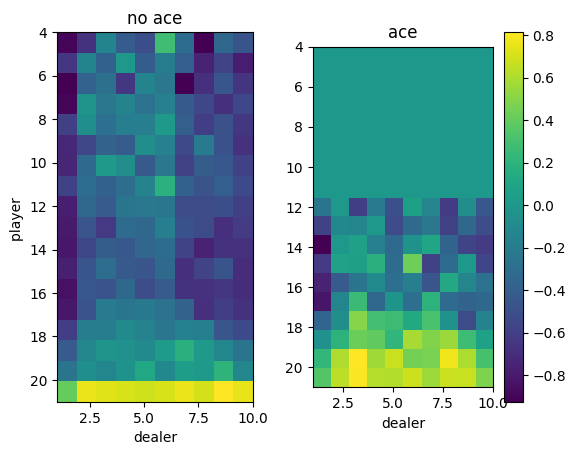

In [34]:
plot_value_function(V)

The score of the player increases the value function takes on higher values so our expected return grows. 
Display the average result of playing ten thousand games with the random policy.

In [38]:
average ,std_win=average_wins(environment,episodes=10000)
print("average number of wins", average)

average number of wins 0.2845


Random policy gives us around $28\%$ of wins. Display the average result of playing ten thousand games with the trained policy.

In [39]:
average ,std_win=average_wins(environment,policy,episodes=10000)
print("average wins:",average)

average wins: 0.4207


More than 10% increase. 

Increase the number of episodes to train our model. 

In [40]:
policy, V, Q,DELTA = monte_carlo_ES( environment,N_episodes=50000, discount_factor=1,first_visit=True,theta=0)  

Display Delta Graph 

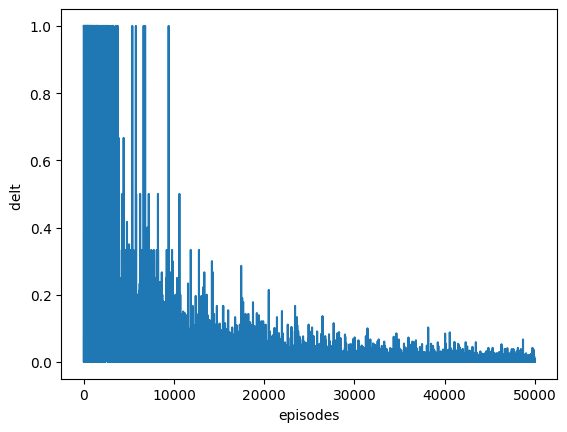

In [41]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt ")
plt.show()

Conerges to $0$. Visualise the policy:

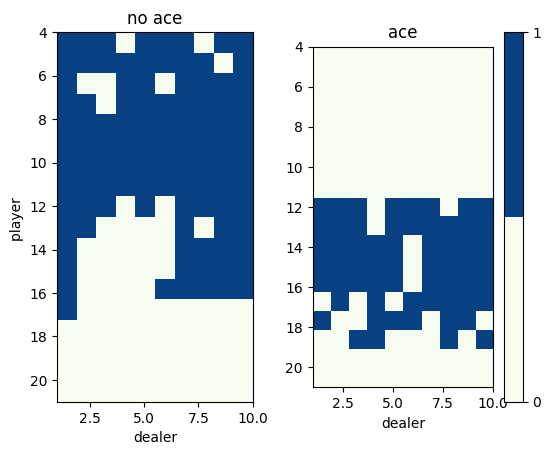

In [42]:
plot_policy_blackjack(policy)

The optimal policy for blackjack is: If the agent has no ace, the higher the dealer is showing, the more likely the agent is to hit, the exception is if the dealer has an ace. If the agent has an ace, the strategy is different. The agent will stick if the sum of their cards is over 11 and, for the most part, hold the player's sum is over 18.

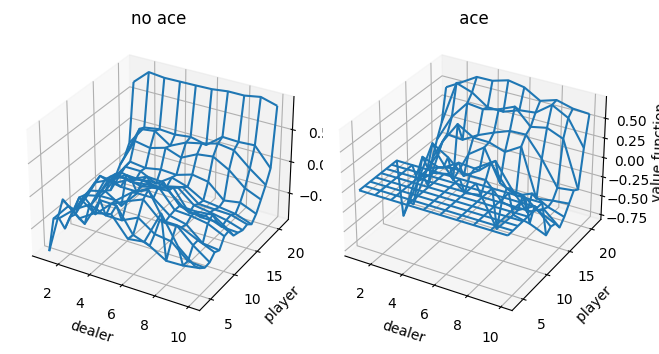

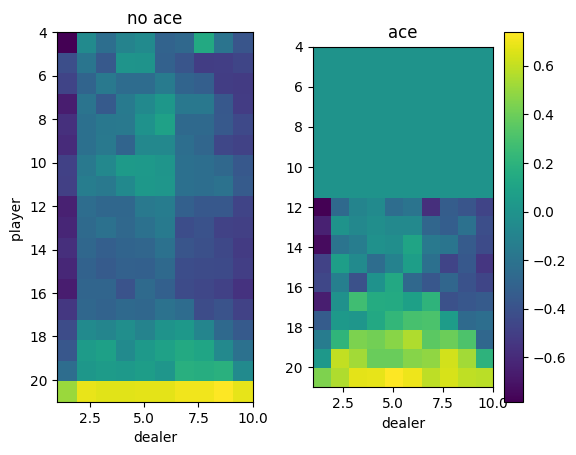

In [43]:
plot_value_function(V)

Compare the accuracy of the results:

In [45]:
average ,std_win=average_wins(environment,policy,episodes=10000)
print("average wins:",average)

average wins: 0.4288


The accuracy is now approximately 43% a 15 % improvement from a random policy:

In [46]:
accuracy = [] 
episodes = []

for n_episode in [1,50,100,500,1000,5000,10000,50000,100000]:
    print("n_episode: ", str(n_episode))
    policy, V, Q, DELTA = monte_carlo_ES( environment,N_episodes=n_episode, discount_factor=1,first_visit=True, theta = 0)  
    average ,std_win = average_wins(environment,policy,episodes=10000)
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy.append(average)
    episodes.append(n_episode)

n_episode:  1
n_episode:  1  average:  0.2802
n_episode:  50
n_episode:  50  average:  0.3073
n_episode:  100
n_episode:  100  average:  0.3368
n_episode:  500
n_episode:  500  average:  0.3777
n_episode:  1000
n_episode:  1000  average:  0.3897
n_episode:  5000
n_episode:  5000  average:  0.4009
n_episode:  10000
n_episode:  10000  average:  0.4266
n_episode:  50000
n_episode:  50000  average:  0.4314
n_episode:  100000
n_episode:  100000  average:  0.4372


After 50000 episodes the improvement is negligible.

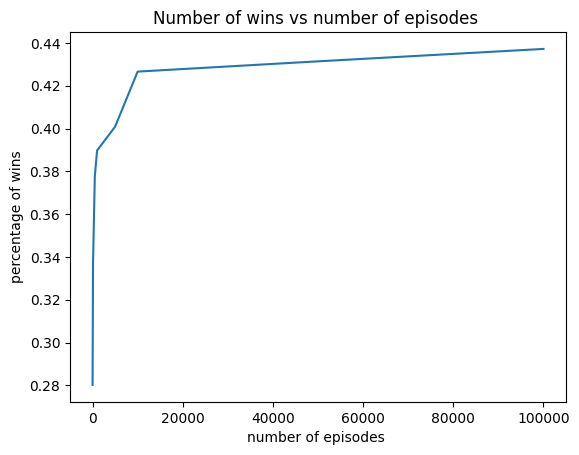

In [47]:
plt.plot(episodes,accuracy)
plt.title("Number of wins vs number of episodes ")
plt.ylabel('percentage of wins')
plt.xlabel('number of episodes ')
plt.show()

Experiment with the discount factor, to see if it changes anything: 

In [48]:
accuracy=[] 
discounts=[]

for discount in [0,0.01,0.1,0.5,1.0]:
    policy, V, Q, delta = monte_carlo_ES( environment,N_episodes=100000, discount_factor=discount,first_visit=True, theta=0)  
    average ,std_win=average_wins(environment,policy,episodes=10000)
    print("discount: ", str(discount), " average: ", str(average))
    discounts.append(discount)
    accuracy.append(average)

discount:  0  average:  0.2736
discount:  0.01  average:  0.3702
discount:  0.1  average:  0.361
discount:  0.5  average:  0.4204
discount:  1.0  average:  0.4321


As the Discount factor increases, the percentage of wins increases, the rate of increase begins to slow down when the discount value is 0.6.

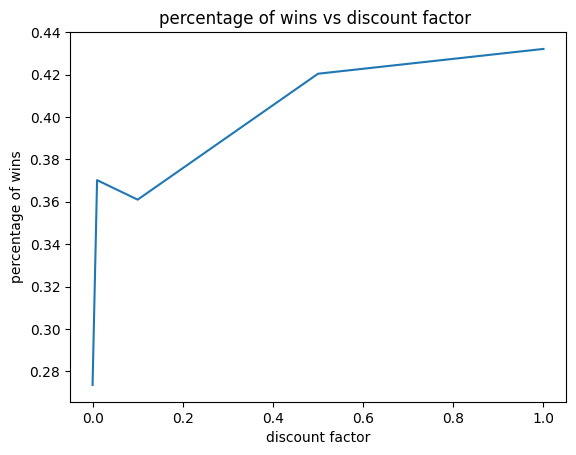

In [49]:
plt.plot(discounts,accuracy)
plt.title("percentage of wins vs discount factor ")
plt.ylabel('percentage of wins')
plt.xlabel('discount factor')
plt.show()

**Conclusion**: have created a successful algorithm, that gave us perhaps not a winning, but an optimal strategy for blackjack. 